# ConTextTab test

In [1]:
import numpy as np
import pandas as pd
import torch
from huggingface_hub import login
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [2]:
from sap_rpt_oss import SAP_RPT_OSS_Classifier

In [3]:
#kaisaniemi = pd.read_csv("data/Kaisaniemi_2023-2025.csv")
#kumpula = pd.read_csv("data/Kumpula_2025.csv")
malmi  = pd.read_csv("data/Malmi_2023-2025.csv")
#df = kaisaniemi
#df = kumpula
df = malmi
df.shape

(26301, 10)

In [4]:
#df = df[df["Vallitseva sää"].isin(['Ei merkittäviä sääilmiöitä ', 'Heikkoa lumisadetta', 'Heikkoja vesikuuroja', 'Utua', 'Heikkoa vesisadetta'])]
df = df[df["Vallitseva sää"].isin(['Heikkoa lumisadetta', 'Heikkoja vesikuuroja', 'Utua'])]
df.shape

(2629, 10)

In [5]:
X = df.drop("Vallitseva sää", axis=1)
y = df["Vallitseva sää"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

classifier = SAP_RPT_OSS_Classifier(max_context_size=8192, bagging=8)

classifier_contexttab = classifier.fit(X_train, y_train)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [6]:
y_predict = classifier_contexttab.predict(X_test)
y_score = classifier_contexttab.predict_proba(X_test)

acc = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average=None)
recall = recall_score(y_test, y_predict, average=None)
f1 = f1_score(y_test, y_predict, average=None)
print(f"accuracy: {acc}")
print(f"precision score: {precision}")
print(f"recall score: {recall}")
print(f"f1-score: {f1}")

y_predict = pd.Series(y_predict)
results = pd.concat([y_test.reset_index(drop=True), y_predict.reset_index(drop=True)], axis=1)
results.columns = ["correct_label", "prediction"]
results.head(10)

accuracy: 0.8973384030418251
precision score: [0.94711538 0.8625     0.86708861]
recall score: [0.95631068 0.87341772 0.84567901]
f1-score: [0.95169082 0.86792453 0.85625   ]


,correct_label,prediction
0,Heikkoja vesikuuroja,Heikkoja vesikuuroja
1,Utua,Heikkoja vesikuuroja
2,Utua,Utua
3,Utua,Utua
4,Heikkoa lumisadetta,Heikkoa lumisadetta
5,Utua,Utua
6,Heikkoa lumisadetta,Heikkoa lumisadetta
7,Heikkoa lumisadetta,Heikkoa lumisadetta
8,Heikkoja vesikuuroja,Heikkoja vesikuuroja
9,Heikkoja vesikuuroja,Heikkoja vesikuuroja


## One-vs-Rest multiclass ROC

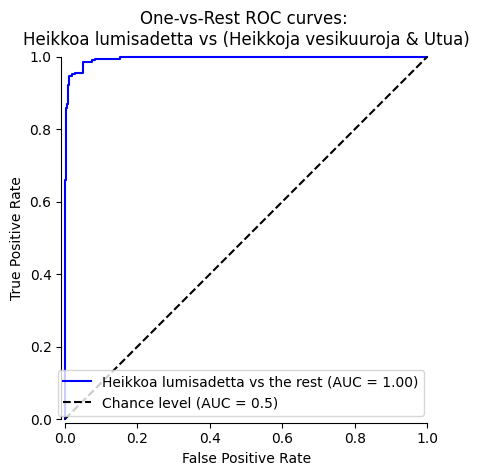

In [7]:
label_binarizer = LabelBinarizer().fit(y_train)
onehot_y_test = label_binarizer.transform(y_test)
class_of_interest = 'Heikkoa lumisadetta'
class_indices = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

display = RocCurveDisplay.from_predictions(
    onehot_y_test[:, class_indices],
    y_score[:, class_indices],
    name=f"{class_of_interest} vs the rest",
    curve_kwargs=dict(color="blue"),
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves: \nHeikkoa lumisadetta vs (Heikkoja vesikuuroja & Utua)",
)

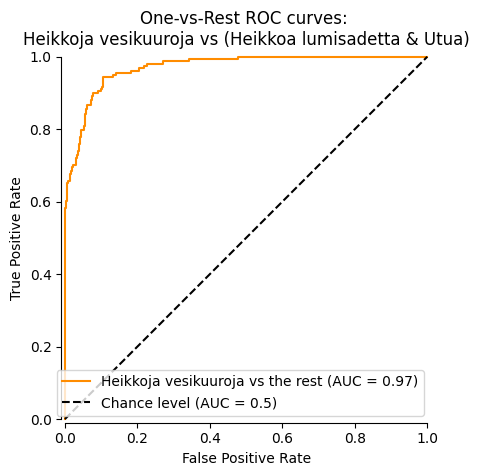

In [8]:
label_binarizer = LabelBinarizer().fit(y_train)
onehot_y_test = label_binarizer.transform(y_test)
class_of_interest = 'Heikkoja vesikuuroja'
class_indices = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

display = RocCurveDisplay.from_predictions(
    onehot_y_test[:, class_indices],
    y_score[:, class_indices],
    name=f"{class_of_interest} vs the rest",
    curve_kwargs=dict(color="darkorange"),
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves: \nHeikkoja vesikuuroja vs (Heikkoa lumisadetta & Utua)",
)

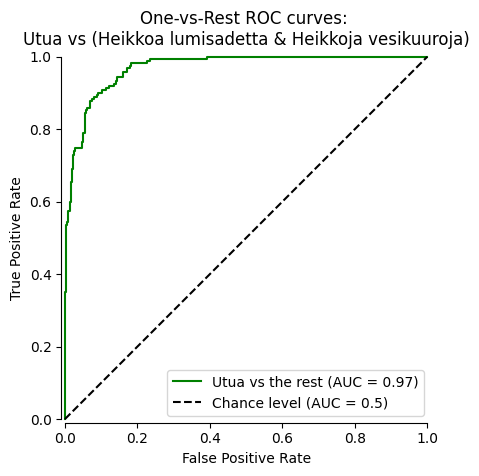

In [9]:
label_binarizer = LabelBinarizer().fit(y_train)
onehot_y_test = label_binarizer.transform(y_test)
class_of_interest = 'Utua'
class_indices = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

display = RocCurveDisplay.from_predictions(
    onehot_y_test[:, class_indices],
    y_score[:, class_indices],
    name=f"{class_of_interest} vs the rest",
    curve_kwargs=dict(color="green"),
    plot_chance_level=True,
    despine=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves: \nUtua vs (Heikkoa lumisadetta & Heikkoja vesikuuroja)",
)

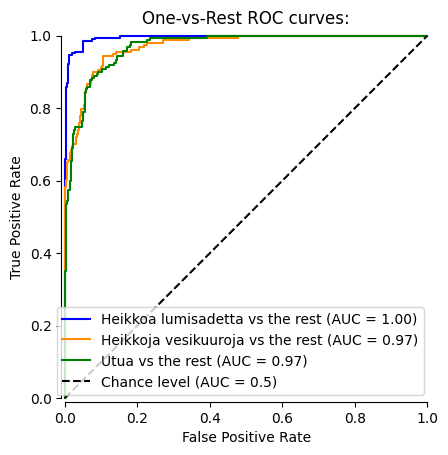

In [10]:
fig, ax = plt.subplots()
colors = ["blue", "darkorange", "green"]
classes = ["Heikkoa lumisadetta", "Heikkoja vesikuuroja", "Utua"]
for class_of_interest, color in zip(classes, colors):
    class_indices = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    RocCurveDisplay.from_predictions(
        onehot_y_test[:, class_indices],
        y_score[:, class_indices],
        name=f"{class_of_interest} vs the rest",
        curve_kwargs=dict(color=color),
        ax=ax,
        plot_chance_level=(class_indices==2),
        despine=True,
    )
_=ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:",
)